In [57]:
import tensorflow

In [58]:
tensorflow.__version__

'2.15.0'

In [59]:
## Importing the libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import imageio
from IPython import display
from skimage.transform import resize
import numpy as np
import os
from PIL import Image

In [8]:
## copy the T1 dataset from google drive to the working directory
!cp -r '/content/drive/MyDrive/GAN/Tr1' '/content/'

In [60]:
# Define the directory containing the images
image_dir = "/content/Tr1/TrainT1"

# Get a list of all image file paths in the directory
image_files = [os.path.join(image_dir,file) for file in os.listdir(image_dir) if file.endswith('png')]

# Initialize an empty list to store the images
images = []

# Loop through each image file, open it, and append its array to the images list
for image_file in image_files:
  with Image.open(image_file) as img:
    img_array = np.array(img)
    images.append(img_array)


# Convert the list of images to a single numpy array
train_images = np.array(images)


# Check the shape of the resulting array
print(train_images.shape)


(43, 217, 181)


array([[1, 2, 2, ..., 1, 1, 1],
       [1, 2, 1, ..., 0, 1, 1],
       [1, 1, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0]], dtype=uint8)
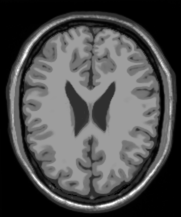

In [61]:
np.array(Image.open(image_files[0]))

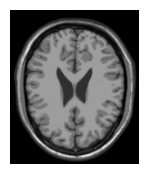

The shape of the image is (217, 181)


In [62]:
#Visualize a sample image
plt.figure(figsize=(2,2))
plt.imshow(train_images[0],cmap='gray')
plt.axis("off")
plt.show()
print(f"The shape of the image is {train_images[0].shape}")

DATA PREPROCESSING

In [63]:
BUFFER_SIZE=43
BATCH_SIZE=10
NOISE_DIM=100

In [64]:
# Normalize the images to [-1.0,1.0]
train_dataset = (train_images/127.5)-1.0

### RESIZE IMAGES TO SIZE(256,256)

In [65]:
train_images = np.zeros((BUFFER_SIZE,256,256))
for index,img in enumerate(train_dataset):
  train_images[index,:,:] = resize(img,output_shape=(256,256))

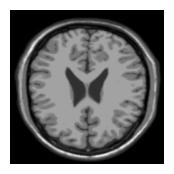

The shape of the image is (256, 256)


In [66]:
## Visualize a sample image
plt.figure(figsize=(2,2))
plt.imshow(train_images[0],cmap='gray')
plt.axis("off")
plt.show()
print(f"The shape of the image is {train_images[0].shape}")

### Reshape Image to add channel dimension

In [67]:
train_images = train_images.reshape(train_images.shape[0],256,256,1).astype('float32')

(256, 256, 1)


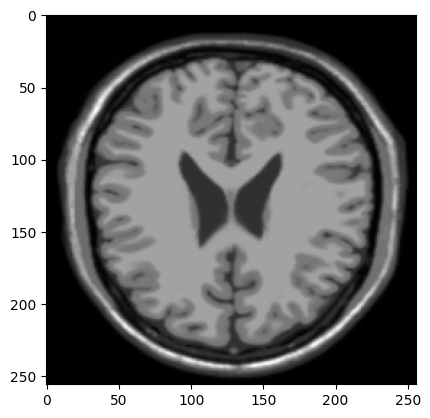

In [68]:
plt.imshow(train_images[0],cmap='gray')
print(train_images[0].shape)

### Shuffle the data and store into Batches

In [69]:
## batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE,seed=42).batch(BATCH_SIZE)

In [70]:
sample = next(iter(train_dataset))
print(sample.shape)

(10, 256, 256, 1)


In [71]:
sample = next(iter(train_dataset))
plt.figure(figsize=(2,2))
plt.imshow(sample[42],cmap='gray')
plt.show()

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 42 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

<Figure size 200x200 with 0 Axes>

### MODEL BUILDING

### Generator Model Building

In [72]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(4*4*512, use_bias=False, input_shape=(NOISE_DIM,))) # 1-D
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((4, 4, 512)))

    model.add(tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), use_bias=False, padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), use_bias=False, padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), use_bias=False, padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), use_bias=False, padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(16, (3, 3), strides=(2, 2), use_bias=False, padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (3, 3), strides=(2, 2), use_bias=False, padding='same', activation='tanh'))

    return model

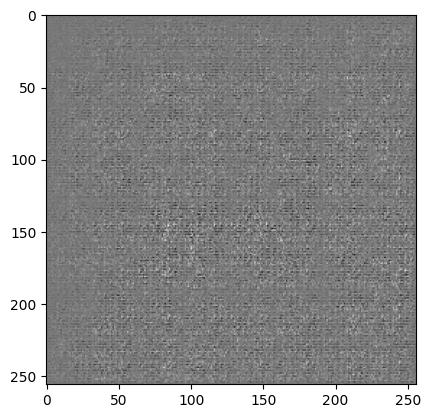

In [73]:
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [74]:
generator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 8192)              819200    
                                                                 
 batch_normalization_25 (Ba  (None, 8192)              32768     
 tchNormalization)                                               
                                                                 
 leaky_re_lu_28 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_3 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_12 (Conv2  (None, 8, 8, 256)         1179648   
 DTranspose)                                                     
                                                                 
 batch_normalization_26 (Ba  (None, 8, 8, 256)        

### Discriminator Model Building

In [75]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(16, (3, 3), strides=(1, 1), use_bias=False,
                                     input_shape=[256, 256, 1]))
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(256, (5, 5), strides=(2, 2), use_bias=False))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2D(1, (10, 10), strides=(1, 1)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))
    return model

In [76]:
discriminator = make_discriminator_model()
print(discriminator.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 254, 254, 16)      144       
                                                                 
 leaky_re_lu_34 (LeakyReLU)  (None, 254, 254, 16)      0         
                                                                 
 conv2d_20 (Conv2D)          (None, 252, 252, 32)      4608      
                                                                 
 batch_normalization_31 (Ba  (None, 252, 252, 32)      128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_35 (LeakyReLU)  (None, 252, 252, 32)      0         
                                                                 
 conv2d_21 (Conv2D)          (None, 250, 250, 64)      18432     
                                                      

In [77]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-4.88555e-05]], shape=(1, 1), dtype=float32)


### MODEL TRAINING

In [78]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [79]:
def discriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [80]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

In [81]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [82]:
EPOCHS = 250

### Checkpoint Initialization

In [83]:
# Directory to keep Generated Images each epoch
if not os.path.isdir('generated_images'):
    os.mkdir('generated_images')

# Directory to save checkpoints
checkpoint_dir = './training_checkpoints'
ckpt = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                               discriminator=discriminator)
ckpt_manager = tf.train.CheckpointManager(checkpoint=ckpt, directory=checkpoint_dir, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

### Training Flow

In [84]:
@tf.function
def train_step(images):
    # Take Noise
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    # To track the gradients for calculation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate Fake Image from Noise
        generated_images = generator(noise, training=True)

        # Check Discriminator's output for Real and Fake Image
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Generator's loss on Fake and Discriminator's loss on both Real and Fake
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate the Gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply Gradients in the optimizer
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [85]:
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, NOISE_DIM])

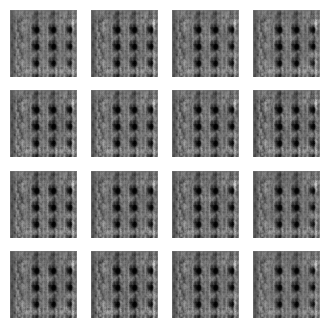

Saving checkpoint for epoch 250 at ./training_checkpoints/ckpt-250


In [86]:
for epoch in range(1, EPOCHS+1):
    for image_batch in train_dataset:
        train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)

    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = generator(seed, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)